In [8]:
import numpy as np
import torch

from floody import data as D
from floody import floody as F

In [9]:
import corner as DFM
# --- plotting ---
import matplotlib as mpl
import matplotlib.pyplot as plt
mpl.rcParams['text.usetex'] = True
mpl.rcParams['font.family'] = 'serif'
mpl.rcParams['axes.linewidth'] = 1.5
mpl.rcParams['axes.xmargin'] = 1
mpl.rcParams['xtick.labelsize'] = 'x-large'
mpl.rcParams['xtick.major.size'] = 5
mpl.rcParams['xtick.major.width'] = 1.5
mpl.rcParams['ytick.labelsize'] = 'x-large'
mpl.rcParams['ytick.major.size'] = 5
mpl.rcParams['ytick.major.width'] = 1.5
mpl.rcParams['legend.frameon'] = False

import matplotlib.patches as patches
from mpl_toolkits.axes_grid1.inset_locator import inset_axes

%matplotlib inline 

In [10]:
cuda = torch.cuda.is_available()
device = ("cuda:0" if cuda else "cpu")

In [11]:
houst_zipcodes = np.array([77002, 77003, 77004, 77005, 77006, 77007, 77008, 77009, 77010, 77011, 77012, 77013, 77014, 77015, 77016, 77017, 77018, 77019, 77020, 77021, 77022, 77023, 77024, 77025, 77026, 77027, 77028, 77029, 77030, 77031, 77032, 77033, 77034, 77035, 77036, 77037, 77038, 77039, 77040, 77041, 77042, 77043, 77044, 77045, 77046, 77047, 77048, 77049, 77050, 77051, 77053, 77054, 77055, 77056, 77057, 77058, 77059, 77060, 77061, 77062, 77063, 77064, 77065, 77066, 77067, 77068, 77069, 77070, 77071, 77072, 77073, 77074, 77075, 77076, 77077, 77078, 77079, 77080, 77082, 77083, 77084, 77085, 77086, 77087, 77088, 77089, 77090, 77092, 77093, 77094, 77095, 77096, 77098, 77099, 77301, 77302, 77303, 77304, 77306, 77316, 77318, 77327, 77328, 77336, 77338, 77339, 77345, 77346, 77354, 77355, 77356, 77357, 77362, 77365, 77372, 77373, 77375, 77377, 77378, 77379, 77380, 77381, 77382, 77384, 77385, 77386, 77388, 77389, 77396, 77401, 77406, 77407, 77423, 77429, 77430, 77433, 77441, 77447, 77449, 77450, 77459, 77461, 77469, 77471, 77477, 77478, 77479, 77480, 77484, 77486, 77489, 77493, 77494, 77498, 77502, 77503, 77504, 77505, 77506, 77510, 77511, 77515, 77517, 77520, 77521, 77530, 77531, 77532, 77534, 77535, 77536, 77539, 77541, 77545, 77546, 77550, 77551, 77554, 77562, 77563, 77565, 77566, 77568, 77571, 77573, 77575, 77578, 77581, 77583, 77584, 77586, 77587, 77590, 77591, 77598, 77650])

In [12]:
houston = D.read_zipshape(houst_zipcodes)

# compile covariates:
1. mean_monthly_rainfall
2. flood_risk100
3. median_household_income
4. population
5. renter_fraction 
6. educated_fraction
7. white_fraction

These are the input for CausalFlow

In [13]:
X_2022 = D.get_X(np.array(houston['ZIPCODE']).astype(int), # zipcodes
                 np.array(houston['LATITUDE']).astype(float), # latitude
                 np.array(houston['LONGITUDE']).astype(float), 
                 2022)
X_2030 = D.get_X(np.array(houston['ZIPCODE']).astype(int), np.array(houston['LATITUDE']).astype(float), 
                 np.array(houston['LONGITUDE']).astype(float), 2030)
X_2040 = D.get_X(np.array(houston['ZIPCODE']).astype(int), np.array(houston['LATITUDE']).astype(float), 
                 np.array(houston['LONGITUDE']).astype(float), 2040)
X_2052 = D.get_X(np.array(houston['ZIPCODE']).astype(int), np.array(houston['LATITUDE']).astype(float), 
                 np.array(houston['LONGITUDE']).astype(float), 2052)

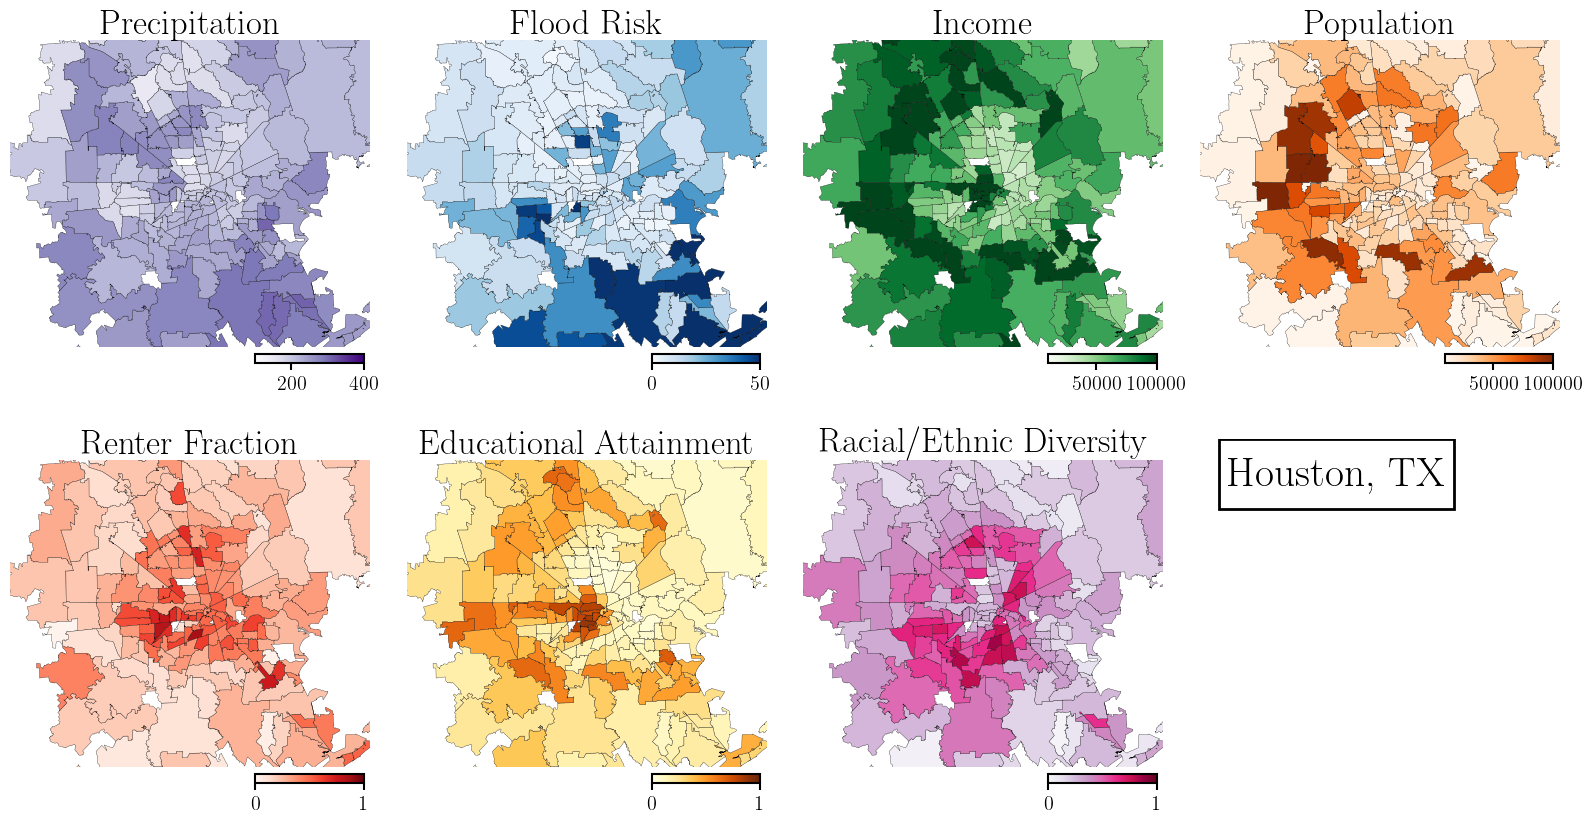

In [14]:
rng = [(100., 400.), (0., 50.), (1e4, 1e5), (1e4, 1e5), (0., 1.), (0., 1.), (0., 1.)]

fig = plt.figure(figsize=(20,10))
for i in range(7): 
    ax = fig.add_subplot(2,4,i+1)
    
    if i == 6: 
        houston['blanck'] = 1.-X_2022[:,i]        
    else:
        houston['blanck'] = X_2022[:,i]

    ax = houston.plot(column='blanck', cmap=['Purples', 'Blues', 'Greens', 'Oranges', 'Reds',
                      'YlOrBr', 'PuRd'][i],  edgecolor='k', linewidth=0.2, 
                      vmin=rng[i][0], vmax=rng[i][1], ax=ax)
    #ax = houston.plot(column='blanck', edgecolor='k', linewidth=1, ax=ax)    
    ax.set_xlim(-96.1, -94.75)
    ax.set_ylim(29.25, 30.25)
    
    lbl = ['Precipitation', 'Flood Risk', 'Income', 'Population', 
           'Renter Fraction', 'Educational Attainment', r'Racial/Ethnic Diversity'][i]
    ax.text(0.5, 1., lbl, transform=ax.transAxes, ha='center', va='bottom', fontsize=25)
    ax.set_axis_off()
    #ax.set_xticks([])
    #ax.set_yticks([])    
    
    sc = ax.scatter([], [], c=[], cmap=['Purples', 'Blues', 'Greens', 'Oranges', 'Reds',
                      'YlOrBr', 'PuRd'][i], vmin=rng[i][0], vmax=rng[i][1])
    cbaxes = inset_axes(ax, width="30%", height="3%", 
                        bbox_to_anchor=(0, -1., 1, 1.),
                        bbox_transform=ax.transAxes)    
    cbar = plt.colorbar(sc, cax=cbaxes, orientation='horizontal')

ax = fig.add_subplot(2,4,8)
ax.text(0.08, 0.95, 'Houston, TX', transform=ax.transAxes, ha='left', va='top', fontsize=30)
rect = patches.Rectangle((0.055, 0.8), 0.65, 0.2, 
                         edgecolor='k', linewidth=2, facecolor='None', transform=ax.transAxes)
ax.add_patch(rect)
ax.set_axis_off()  


fig.subplots_adjust(hspace=0.2, wspace=0.1)
#fig.tight_layout()

In [15]:
median_losses = np.zeros((4, X_2022.shape[0]))
sig_median_losses = np.zeros((4, X_2022.shape[0]))

for i, zcode in enumerate(np.array(houston['ZIPCODE']).astype(int)): 
    for j, _X in enumerate([X_2022, X_2030, X_2040, X_2052]):
        
        _med_losses = [] 
        for _i in range(11): 
            _losses = F.flood_loss(_X[i,0], _X[i,1], _X[i,2], _X[i,3], _X[i,4], _X[i,5], _X[i,6],
                              Nsample=10000, support_threshold=0.99, device=None)
            _med_losses.append(np.median(_losses))
            
        median_losses[j, i] = np.median(_med_losses)
        sig_median_losses[j, i] = np.std(_med_losses)

/home/chhahn/projects/floody/src/floody/floody.py:43: UserWarning: X is out of support
  if not in_support: warnings.warn("X is out of support")


In [16]:
# save to file 
np.save('houston.median_flood_losses.npy', median_losses)
np.save('houston.sig_median_flood_losses.npy', sig_median_losses)

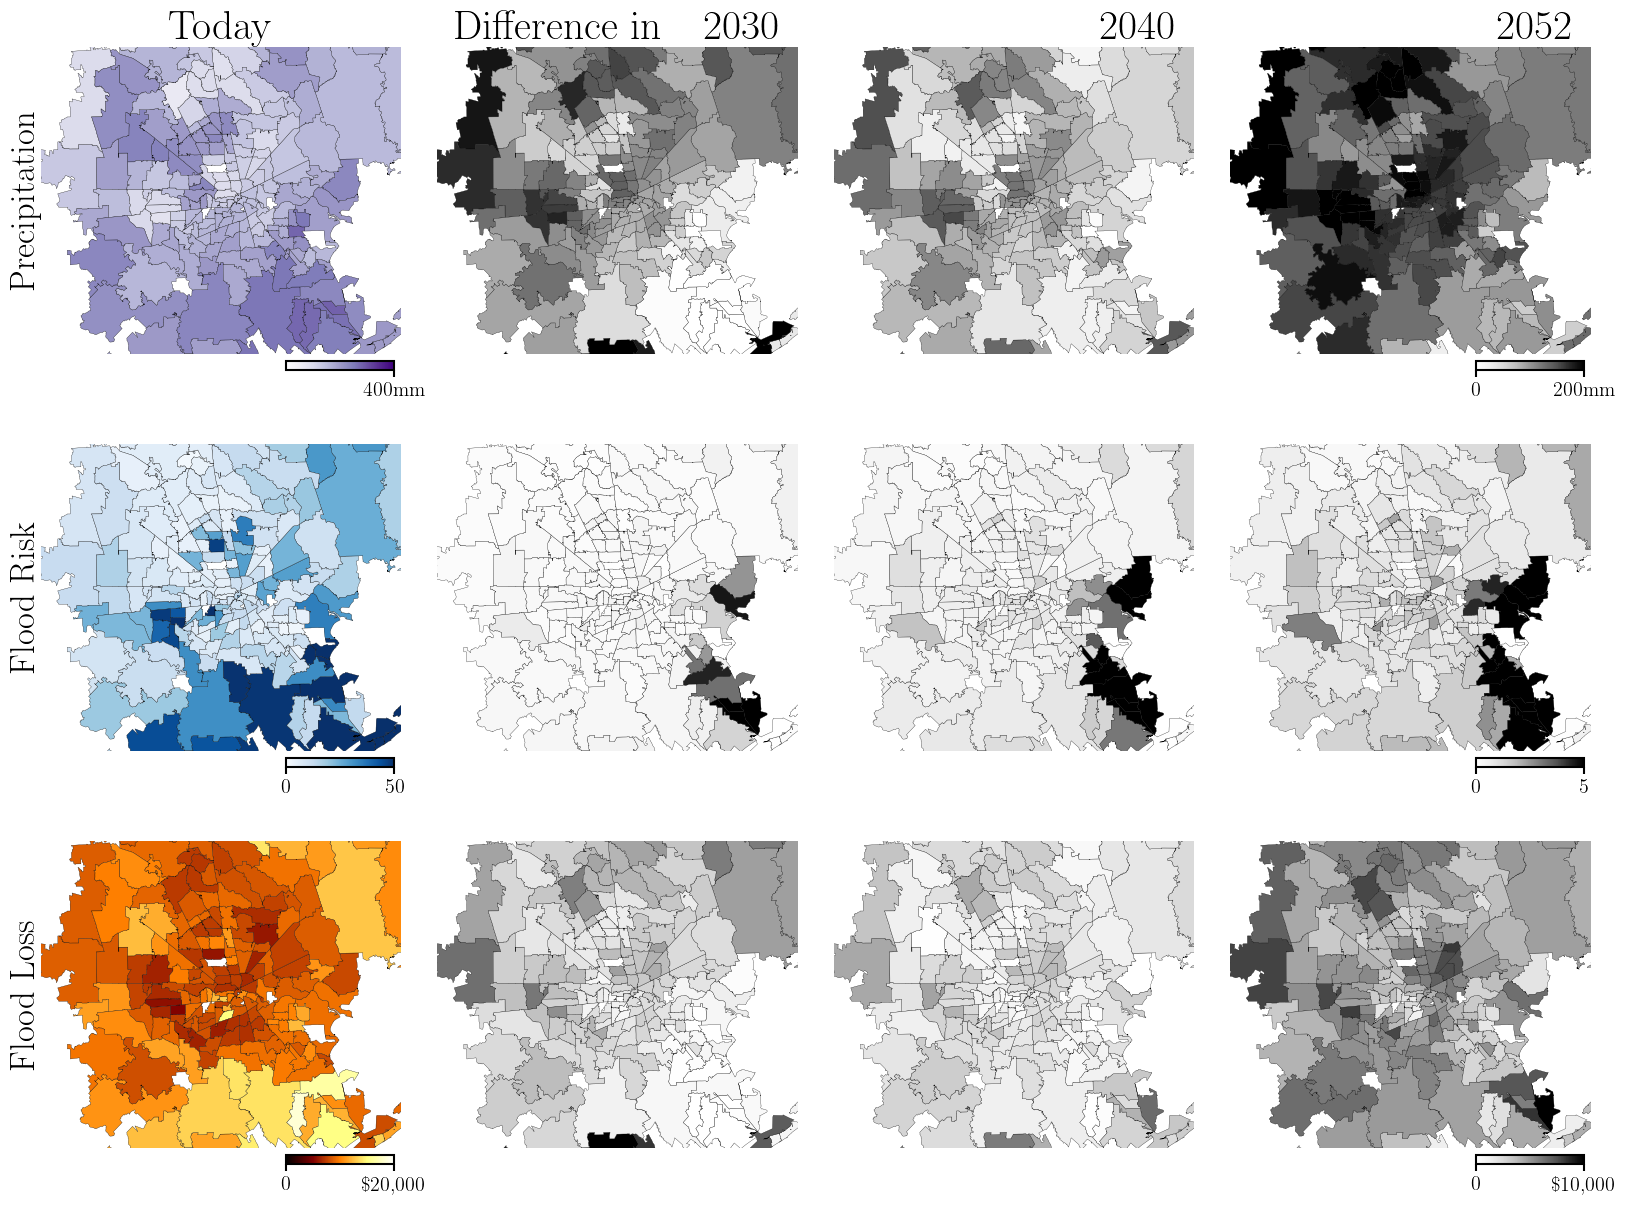

In [13]:
# create map figure and axes
fig = plt.figure(figsize=(20,15))
for i in range(4): 
    ax = fig.add_subplot(3,4,i+1)
    
    if i == 0: 
        houston['blanck'] = X_2022[:,0]
    else: 
        houston['blanck'] = ([None, X_2030, X_2040, X_2052][i])[:,0] - X_2022[:,0]
    ax = houston.plot(column='blanck', cmap=['Greys', 'Purples'][i == 0], edgecolor='k', linewidth=0.2, 
                      vmin=[0., 100.][i == 0], vmax=[200., 400][i == 0], ax=ax)

    ax.set_xlim(-96.1, -94.75)
    ax.set_ylim(29.25, 30.25)
    
    if i == 0: ax.text(0.0, 0.5, 'Precipitation', rotation=90., transform=ax.transAxes, ha='right', va='center', fontsize=25)
    if i == 1: ax.text(0.05, 1.0, 'Difference in', transform=ax.transAxes, ha='left', va='bottom', fontsize=30)
    ax.set_axis_off()
    if i == 0: ax.set_title('Today', fontsize=30)
    else: ax.text(0.95, 1.0, ['2030', '2040', '2052'][i-1], 
                  transform=ax.transAxes, ha='right', va='bottom', fontsize=30)    
    if i in [0, 3]: 
        sc = ax.scatter([], [], c=[], cmap=['Greys', 'Purples'][i == 0], 
                        vmin=[0., 100.][i == 0], vmax=[200., 400][i == 0])
        cbaxes = inset_axes(ax, width="30%", height="3%", 
                            bbox_to_anchor=(0, -1., 1, 1.),
                            bbox_transform=ax.transAxes) 
        cbar = plt.colorbar(sc, ticks=[0, [200., 400.][i==0]], cax=cbaxes, orientation='horizontal')
        cbar.ax.set_xticklabels(['0', ['200mm', '400mm'][i==0]])

    # Flood risk
    ax = fig.add_subplot(3,4,i+5)
    if i == 0: 
        houston['blanck'] = X_2022[:,1]
    else: 
        houston['blanck'] = ([None, X_2030, X_2040, X_2052][i])[:,1] - X_2022[:,1]
    
    ax = houston.plot(column='blanck', cmap=['Greys', 'Blues'][i == 0], edgecolor='k', linewidth=0.2,  
                      vmin=[0., 0.][i == 0], vmax=[5., 50][i == 0], ax=ax)
    if i == 0: ax.axvline(-94.74, color='k', linewidth=1)

    ax.set_xlim(-96.1, -94.75)
    ax.set_ylim(29.25, 30.25)
    
    if i == 0: ax.text(0.0, 0.5, 'Flood Risk', rotation=90., transform=ax.transAxes, ha='right', va='center', fontsize=25)
    #if i == 1: ax.text(0.05, 0.95, 'Differences', color='white', transform=ax.transAxes, ha='left', va='top', fontsize=25)
    ax.set_axis_off()
    
    if i in [0, 3]: 
        sc = ax.scatter([], [], c=[], cmap=['Greys', 'Blues'][i == 0], 
                        vmin=[0., 0.][i == 0], vmax=[5., 50][i == 0])
        cbaxes = inset_axes(ax, width="30%", height="3%", 
                            bbox_to_anchor=(0, -1., 1, 1.),
                            bbox_transform=ax.transAxes)
        cbar = plt.colorbar(sc, cax=cbaxes, orientation='horizontal')    

    
    # flood loss
    ax = fig.add_subplot(3,4,i+9)
    if i == 0: 
        houston['blanck'] = median_losses[0,:]
    else: 
        houston['blanck'] = median_losses[i,:] - median_losses[0,:]
    
    ax = houston.plot(column='blanck', cmap=['Greys', 'afmhot'][i == 0], edgecolor='k', linewidth=0.2,  
                      vmin=[0., 0.][i == 0], vmax=[1e4, 2e4][i == 0], ax=ax)
    if i == 0: ax.axvline(-94.74, color='k', linewidth=1)

    ax.set_xlim(-96.1, -94.75)
    ax.set_ylim(29.25, 30.25)
    
    if i == 0: ax.text(0.0, 0.5, 'Flood Loss', rotation=90., transform=ax.transAxes, ha='right', va='center', fontsize=25)
    #if i == 1: ax.text(0.05, 0.95, 'Differences', transform=ax.transAxes, ha='left', va='top', fontsize=25)
    ax.set_axis_off()
    
    if i in [0, 3]: 
        sc = ax.scatter([], [], c=[], cmap=['Greys', 'afmhot'][i == 0], 
                        vmin=[0., 0.][i == 0], vmax=[1e4, 2e4][i == 0])
        cbaxes = inset_axes(ax, width="30%", height="3%", 
                            bbox_to_anchor=(0, -1., 1, 1.),
                            bbox_transform=ax.transAxes)
        cbar = plt.colorbar(sc, ticks=[0, [1e4, 2e4][i == 0]], cax=cbaxes, orientation='horizontal')
        cbar.ax.set_xticklabels(['0', [r'\$10,000', r'\$20,000'][i==0]])
    
fig.subplots_adjust(hspace=0.1, wspace=0.1)

In [ ]:
savings = np.zeros((4, X_2022.shape[0]))
sig_savings = np.zeros((4, X_2022.shape[0]))
for i, zcode in enumerate(np.array(houston['ZIPCODE']).astype(int)): 
    for j, _X in enumerate([X_2022, X_2030, X_2040, X_2052]):
        
        _savings = []
        for _i in range(11): 
            _saving = F.flood_saving(_X[i,0], _X[i,1], _X[i,2], _X[i,3], _X[i,4], _X[i,5], _X[i,6],
                              Nsample=10000, support_threshold=0.99, device=None)
            _savings.append(_saving)
        
        savings[j, i] = np.median(_savings)
        sig_savings[j, i] = np.std(_savings)

/home/chhahn/projects/CausalFlow/src/causalflow/causalflow.py:329: UserWarning: covariate is out of the treated sample support!
  warnings.warn("covariate is out of the treated sample support!")
/home/chhahn/projects/CausalFlow/src/causalflow/causalflow.py:331: UserWarning: covariate is out of the control sample support!
  warnings.warn("covariate is out of the control sample support!")


In [ ]:
# save to file 
np.save('houston.flood_savings.npy', savings)
np.save('houston.sig_flood_savings.npy', sig_savings)

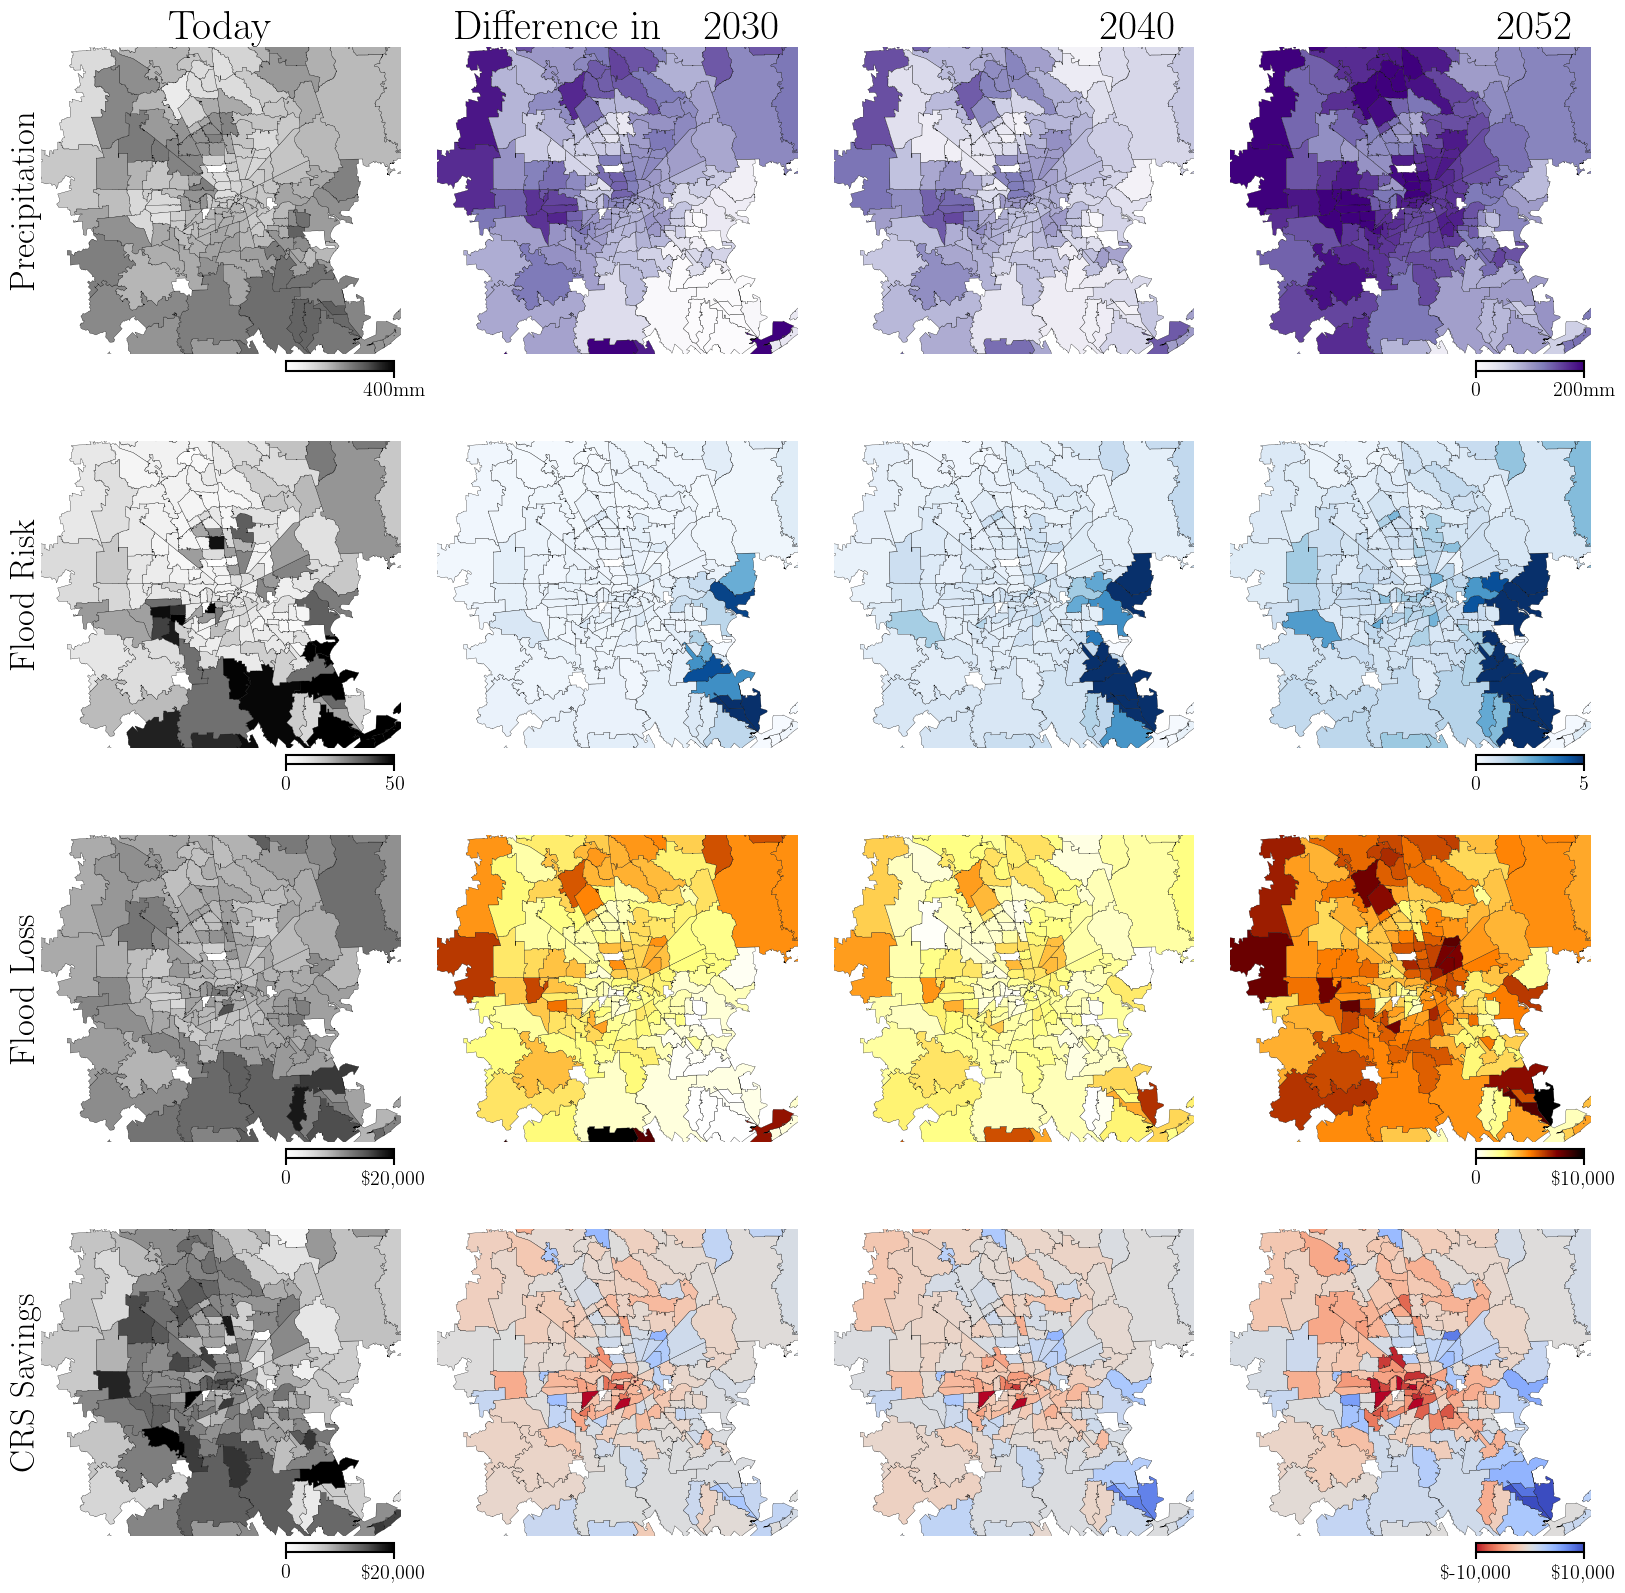

In [39]:
# create map figure and axes
fig = plt.figure(figsize=(20,20))
for i in range(4): 
    ax = fig.add_subplot(4,4,i+1)
    
    if i == 0: 
        houston['blanck'] = X_2022[:,0]
    else: 
        houston['blanck'] = ([None, X_2030, X_2040, X_2052][i])[:,0] - X_2022[:,0]
    ax = houston.plot(column='blanck', cmap=['Greys', 'Purples'][i != 0], edgecolor='k', linewidth=0.2, 
                      vmin=[0., 100.][i == 0], vmax=[200., 400][i == 0], ax=ax)

    ax.set_xlim(-96.1, -94.75)
    ax.set_ylim(29.25, 30.25)
    
    if i == 0: ax.text(0.0, 0.5, 'Precipitation', rotation=90., transform=ax.transAxes, ha='right', va='center', fontsize=25)
    if i == 1: ax.text(0.05, 1.0, 'Difference in', transform=ax.transAxes, ha='left', va='bottom', fontsize=30)
    ax.set_axis_off()
    if i == 0: ax.set_title('Today', fontsize=30)
    else: ax.text(0.95, 1.0, ['2030', '2040', '2052'][i-1], 
                  transform=ax.transAxes, ha='right', va='bottom', fontsize=30)    
    if i in [0, 3]: 
        sc = ax.scatter([], [], c=[], cmap=['Greys', 'Purples'][i != 0], 
                        vmin=[0., 100.][i == 0], vmax=[200., 400][i == 0])
        cbaxes = inset_axes(ax, width="30%", height="3%", 
                            bbox_to_anchor=(0, -1., 1, 1.),
                            bbox_transform=ax.transAxes) 
        cbar = plt.colorbar(sc, ticks=[0, [200., 400.][i==0]], cax=cbaxes, orientation='horizontal')
        cbar.ax.set_xticklabels(['0', ['200mm', '400mm'][i==0]])

    # Flood risk
    ax = fig.add_subplot(4,4,i+5)
    if i == 0: 
        houston['blanck'] = X_2022[:,1]
    else: 
        houston['blanck'] = ([None, X_2030, X_2040, X_2052][i])[:,1] - X_2022[:,1]
    
    ax = houston.plot(column='blanck', cmap=['Greys', 'Blues'][i != 0], edgecolor='k', linewidth=0.2,  
                      vmin=[0., 0.][i == 0], vmax=[5., 50][i == 0], ax=ax)
    if i == 0: ax.axvline(-94.74, color='k', linewidth=1)

    ax.set_xlim(-96.1, -94.75)
    ax.set_ylim(29.25, 30.25)
    
    if i == 0: ax.text(0.0, 0.5, 'Flood Risk', rotation=90., transform=ax.transAxes, ha='right', va='center', fontsize=25)
    #if i == 1: ax.text(0.05, 0.95, 'Differences', color='white', transform=ax.transAxes, ha='left', va='top', fontsize=25)
    ax.set_axis_off()
    
    if i in [0, 3]: 
        sc = ax.scatter([], [], c=[], cmap=['Greys', 'Blues'][i != 0], 
                        vmin=[0., 0.][i == 0], vmax=[5., 50][i == 0])
        cbaxes = inset_axes(ax, width="30%", height="3%", 
                            bbox_to_anchor=(0, -1., 1, 1.),
                            bbox_transform=ax.transAxes)
        cbar = plt.colorbar(sc, cax=cbaxes, orientation='horizontal')    

    
    # flood loss
    ax = fig.add_subplot(4,4,i+9)
    if i == 0: 
        houston['blanck'] = median_losses[0,:] 
    else: 
        houston['blanck'] = median_losses[i,:] - median_losses[0,:]
    
    ax = houston.plot(column='blanck', cmap=['Greys', 'afmhot_r'][i != 0], edgecolor='k', linewidth=0.2,  
                      vmin=[0., 0.][i == 0], vmax=[1e4, 2e4][i == 0], ax=ax)
    if i == 0: ax.axvline(-94.74, color='k', linewidth=1)

    ax.set_xlim(-96.1, -94.75)
    ax.set_ylim(29.25, 30.25)
    
    if i == 0: ax.text(0.0, 0.5, 'Flood Loss', rotation=90., transform=ax.transAxes, ha='right', va='center', fontsize=25)
    #if i == 1: ax.text(0.05, 0.95, 'Differences', transform=ax.transAxes, ha='left', va='top', fontsize=25)
    ax.set_axis_off()
    
    if i in [0, 3]: 
        sc = ax.scatter([], [], c=[], cmap=['Greys', 'afmhot_r'][i != 0], 
                        vmin=[0., 0.][i == 0], vmax=[1e4, 2e4][i == 0])
        cbaxes = inset_axes(ax, width="30%", height="3%", 
                            bbox_to_anchor=(0, -1., 1, 1.),
                            bbox_transform=ax.transAxes)
        cbar = plt.colorbar(sc, ticks=[0, [1e4, 2e4][i == 0]], cax=cbaxes, orientation='horizontal')
        cbar.ax.set_xticklabels(['0', [r'\$10,000', r'\$20,000'][i==0]])
        
    # CFS flood saving
    ax = fig.add_subplot(4,4,i+13)
    if i == 0: 
        houston['blanck'] = -savings[:,0] + 9780.0 # outreach impact
    else: 
        houston['blanck'] = -savings[:,i] + savings[:,0]
    
    ax = houston.plot(column='blanck', cmap=['Greys', 'coolwarm_r'][i != 0], edgecolor='k', linewidth=0.2,  
                      vmin=[-1e4, 0.][i == 0], vmax=[1e4, 2e4][i == 0], ax=ax)
    if i == 0: ax.axvline(-94.74, color='k', linewidth=1)

    ax.set_xlim(-96.1, -94.75)
    ax.set_ylim(29.25, 30.25)
    
    if i == 0: ax.text(0.0, 0.5, 'CRS Savings', rotation=90., transform=ax.transAxes, ha='right', va='center', fontsize=25)
    #if i == 1: ax.text(0.05, 0.95, 'Differences', transform=ax.transAxes, ha='left', va='top', fontsize=25)
    ax.set_axis_off()
    
    if i in [0, 3]: 
        sc = ax.scatter([], [], c=[], cmap=['Greys', 'coolwarm_r'][i != 0], 
                        vmin=[-1e4, 0.][i == 0], vmax=[1e4, 2e4][i == 0])
        cbaxes = inset_axes(ax, width="30%", height="3%", 
                            bbox_to_anchor=(0, -1., 1, 1.),
                            bbox_transform=ax.transAxes)
        cbar = plt.colorbar(sc, ticks=[[-1e4, 0][i==0], [1e4, 2e4][i == 0]], cax=cbaxes, orientation='horizontal')
        cbar.ax.set_xticklabels([[r'\$-10,000', '0'][i==0], [r'\$10,000', r'\$20,000'][i==0]])        
    
fig.subplots_adjust(hspace=0.1, wspace=0.1)